In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import json
import os
from os.path import dirname, join
from pdb import set_trace

import jupytools
import jupytools.syspath
import pandas as pd

jupytools.syspath.add(join(dirname(os.getcwd()), 'protein_project'))
jupytools.syspath.add('rxrx1-utils')
if jupytools.is_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm as tdqm
    
import contextlib, io
with contextlib.redirect_stderr(io.StringIO()):
    from augmentation import Augmented, multichannel_norm
    from basedir import ROOT
    from dataset import load_data, RxRxDataset
    from visual import rgb, six, show_1, show

## Data Loading

In [2]:
data_dict = load_data()
train_dataset, test_dataset = data_dict['data']
# train_dataset[:1]

In [3]:
with open('channels.json') as f:
    stats = json.load(f)

In [4]:
# stats[0]

In [5]:
def pull_key(records, key, no_duplicates=True):
    stacked = {}
    if isinstance(key, str):
        key = [key]
        
    def extract_key(record, key):
        reference = []
        for part in key:
            if part not in record:
                print(f'Record #{i}: the key is "{part}" missing.')
                return None
            reference.append(record.pop(part))
        return tuple(reference)
    
    for i, record in enumerate(records):
        reference = extract_key(record, key)
        if reference is None:
            continue
        if reference in stacked and no_duplicates:
            raise ValueError(f'key value is duplicated: {reference}')
        stacked[reference] = record
    return stacked

In [6]:
train_dataset_index = pull_key(train_dataset, ['id_code', 'site'])
train_stats_index = pull_key(stats, ['id_code', 'site'])

(6, 512, 512)
38
(6, 384, 384)


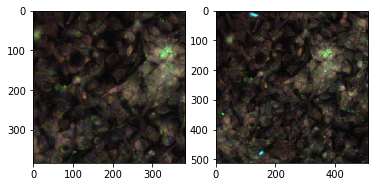

In [38]:
import numpy as np
import matplotlib.pyplot as plt
im = six(train_dataset[0])
print(im.shape)
size = 512
crop = 384
shift = np.random.randint(0, size - crop - 1)
print(shift)
cropped = im[:, shift:(shift+crop), shift:(shift+crop)]
print(cropped.shape)
f, ax = plt.subplots(1, 2)
ax[0].imshow(cropped[3:6, :, :].transpose(1, 2, 0))
ax[1].imshow(im[3:6, :, :].transpose(1, 2, 0))

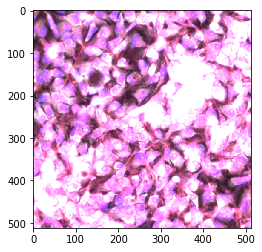

In [7]:
key = ('HEPG2-01_1_B03', 1)
x = train_dataset_index[key]
show_1(six(x))

In [8]:
experiments = sorted(set([record['experiment'] for record in train_dataset]))
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

In [9]:
def take_sample(df, num_per_exp=1):
    samples = (df
        .groupby('experiment', as_index=False)
        .apply(lambda g: g.sample(num_per_exp))
        .reset_index(drop=True))
    records = samples[['experiment', 'enc_sirna', 'images']].to_dict('records')
    return records

## Show Experiments

In [ ]:
def show_sample(df, num_per_exp=1, ncols=4):
    records = take_sample(df, num_per_exp)
    experiments = [r['experiment'] for r in records]
    sirnas = [str(r['enc_sirna']) for r in records]
    titles = ['/'.join(pair) for pair in zip(experiments, sirnas)]
    images = [six(r) for r in tqdm(records)]
    show(*images, titles=titles, ncols=ncols)

In [ ]:
show_sample(train_df, num_per_exp=3, ncols=9)

In [ ]:
# show_sample(test_df, num_per_exp=4, ncols=12)

## Images Normalization

In [ ]:
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

sample = take_sample(train_df, num_per_exp=1)
n = len(sample)
n_cols = 6
n_rows = int(np.ceil(n / n_cols))
print(f'total={n}, n_rows={n_rows}, n_cols={n_cols}')

f, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14))
for ax in axes.flat:
    ax.axis('off')
for i in range(n):
    ax = axes.flat[i]
    img = six(sample[i]).astype(float)
    for channel in img:
        sns.kdeplot(channel.ravel(), ax=ax)
    ax.set_title(f"{sample[i]['experiment']}\nsirna={sample[i]['enc_sirna']}")
    ax.axis('on')
f.subplots_adjust(hspace=1)

In [ ]:
import json
from visual import six, rgb
from augmentation import multichannel_norm

In [ ]:
with open('exp_channelwise_stats.json') as f:
    stats = json.load(f)

In [ ]:
n = len(sample)
n_cols = 6
n_rows = int(np.ceil(n / n_cols))
print(f'total={n}, n_rows={n_rows}, n_cols={n_cols}')

f, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14))
for ax in axes.flat:
    ax.axis('off')
for i in range(n):
    ax = axes.flat[i]
    img = six(sample[i])
    img_norm = multichannel_norm(img.astype(float), stats[sample[i]['experiment']])
    for channel in img_norm:
        sns.kdeplot(channel.ravel(), ax=ax)
    ax.set_title(f"{sample[i]['experiment']}\nsirna={sample[i]['enc_sirna']}")
    ax.axis('on')
f.subplots_adjust(hspace=1)

In [ ]:
n = len(sample)
n_cols = 6
n_rows = int(np.ceil(n / n_cols))
print(f'total={n}, n_rows={n_rows}, n_cols={n_cols}')

f, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14))
for ax in axes.flat:
    ax.axis('off')
for i in range(n):
    ax = axes.flat[i]
    img = six(sample[i])
    img_norm = multichannel_norm(img.astype(float), stats[sample[i]['experiment']])
    img_norm = np.clip(img_norm, -3, 3)
    for channel in img_norm:
        sns.kdeplot(channel.ravel(), ax=ax)
    ax.set_title(f"{sample[i]['experiment']}\nsirna={sample[i]['enc_sirna']}")
    ax.axis('on')
f.subplots_adjust(hspace=1)

## Images Filtering

In [41]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [42]:
def load_data_raw(filenames=None):
    if filenames is None:
        filenames = [f'{fn}.json' for fn in ('train', 'test')]
    data = [json.load(open(filename)) for filename in filenames]
    return data

In [43]:
trn_rec, tst_rec = load_data_raw()

In [44]:
def show_channels(records, figsize=(12, 12)):
    f, axes = plt.subplots(len(records), 7, figsize=figsize)
    for i, record in enumerate(records):
        img = six(record)
        id_code = f"{record['experiment']}/{record['sirna']}"
        for j, channel in enumerate(img):
            ax = axes[i][j]
            ax.imshow(channel, cmap='gray')
            ax.set_title(f'{id_code}\n(channel #{j})')
            ax.axis('off')
        axes[i][-1].imshow(rgb(img))
        axes[i][-1].set_title('RGB')
        axes[i][-1].axis('off')
    f.subplots_adjust(hspace=0.5)

In [45]:
def show_channels_image(images, figsize=(12, 12)):
    f, axes = plt.subplots(len(images), 7, figsize=figsize)
    for i, image in enumerate(images):
        for j, channel in enumerate(image):
            ax = axes[i][j]
            ax.imshow(channel, cmap='gray')
            ax.axis('off')
        axes[i][-1].imshow(rgb(image))
        axes[i][-1].set_title('RGB')
        axes[i][-1].axis('off')
    f.subplots_adjust(hspace=0.5)

In [72]:
# kernel = np.ones((32, 32),np.uint8)
kernel = np.ones((128, 128), np.uint8)

In [73]:
# sample = np.random.choice(trn_rec, 6)
sample = trn_rec[:6]

In [82]:
cv.morphologyEx(six(sample[0]), cv.MORPH_TOPHAT, kernel).max()

246

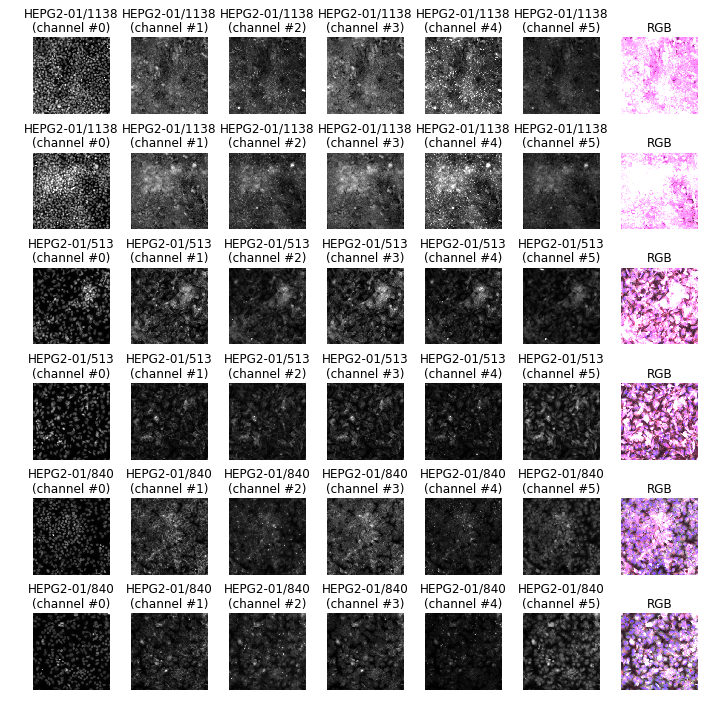

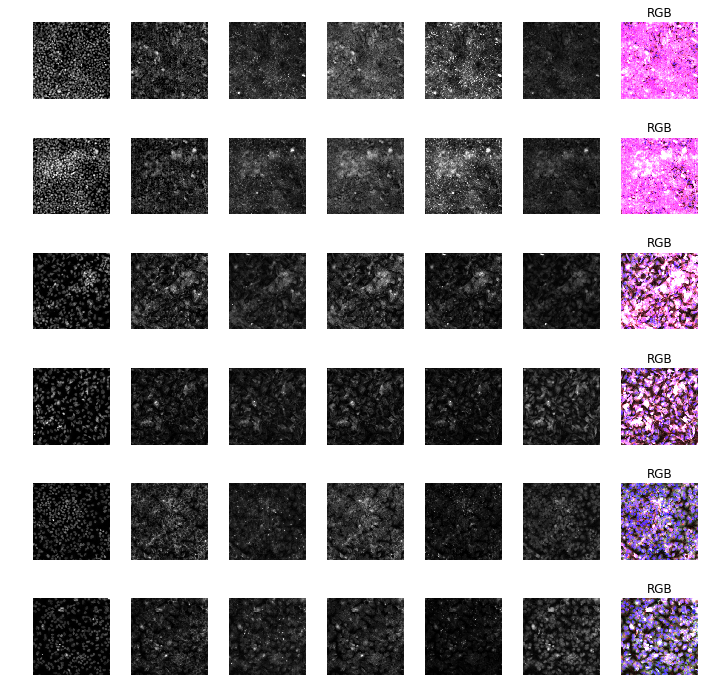

In [77]:
show_channels(sample)
tophats = [np.clip(cv.morphologyEx(six(record), cv.MORPH_TOPHAT, kernel), 0, 255)
                   for record in sample]
show_channels_image(tophats)

In [75]:
# pd.read_csv(ROOT/'pixel_stats.csv')